<h2>Прогнозирование при помощи нейросети LSTM, ч. 2</h2>

<h3>Импорт библиотек</h3>

In [1]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

C:\Python311\Lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
from lightning.pytorch.tuner import Tuner

In [4]:
import pandas as pd
import matplotlib.pyplot  as plt
import os

<h3>Импорт данных</h3>

In [5]:
dirname = os.path.join(os.path.abspath(os.curdir), 'underwork')

raw_data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}
for v in raw_data:
    tsdf_c = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    tsdf_w = pd.read_csv(os.path.join(os.sep, dirname, v, 'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    raw_data[v] = (tsdf_c, tsdf_w, tsdf_m)

In [6]:
data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}

for v in raw_data:
    calm = raw_data[v][0]
    work = raw_data[v][1]
    sex = raw_data[v][2].iloc[0]["values"]
    weight = raw_data[v][2].iloc[1]["values"]
    height = raw_data[v][2].iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    data[v] = (calm, work)

In [7]:
validation = {"25":(), "27":()}
for v in validation:
    calm = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    work = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    sex = tsdf_m.iloc[0]["values"]
    weight = tsdf_m.iloc[1]["values"]
    height = tsdf_m.iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    validation[v] = (calm, work)

In [8]:
data["8"][1].head()

,Time,1,2,3,4,5,6,sex,weight,height,state
0,0.000,0.879447,0.542609,1.484108,1.932941,0.991373,1.013162,0.0,78.0,175.0,1
1,0.001,0.887681,0.552804,1.478226,1.923922,0.998824,1.015515,0.0,78.0,175.0,1
2,0.002,0.894347,0.561431,1.472736,1.916471,1.005490,1.017083,0.0,78.0,175.0,1
3,0.003,0.901406,0.568881,1.466462,1.909412,1.012157,1.017476,0.0,78.0,175.0,1
4,0.004,0.907288,0.574763,1.460580,1.903529,1.018039,1.017476,0.0,78.0,175.0,1


<h3>Подготовка данных</h3>

In [9]:
import torch
import torch.nn as nn

In [10]:
def data_split(ts, param="1", train_percentage=0.67):
    timeseries = ts[["1"]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [11]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    x, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        x.append(feature)
        y.append(target)
    return torch.tensor(x), torch.tensor(y)

In [12]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [13]:
ts = pd.DataFrame()

for v in data:
   calm = data[v][0]
   work = data[v][1]
   ts = pd.concat([ts, calm, work], sort=False, axis=0)

train, test, total = data_split(ts)
lookback = 1
x_train, y_train = create_dataset(train, lookback=lookback)
x_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\artem\AppData\Local\Temp\ipykernel_9980\2827343460.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(x), torch.tensor(y)


<h3>Обучение нейросети</h3>

In [14]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data

In [15]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return y_pred_train, y_pred_test, model

In [17]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(x_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 20

In [19]:
y_pred_train, y_pred_test, model = train_model(model, x_train, x_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 0.0063, test RMSE 0.0150
Epoch 10: train RMSE 0.0071, test RMSE 0.0153


In [20]:
torch.save(model, f"./lstm_forecast_{EPOCHS}_epochs.pth")

<h3>Метрика</h3>

In [21]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [22]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
    # shift train predictions for plotting
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, :]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1, :]
        # shift test predictions for plotting
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1, :]

    plt.rcParams["figure.figsize"] = [12, 7]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

In [23]:
def validate_on_new_users(model):
    for v in validation:
        calm = validation[v][0]
        work = validation[v][1]
        valid = pd.concat([calm, work], sort=False, axis=0)
        valid_train, valid_test, valid_total = data_split(valid)
        
        lookback = 1
        X_train, _ = create_dataset(valid_train, lookback=lookback)
        X_test, y_test = create_dataset(valid_test, lookback=lookback)

        y_pred = model(X_test)
        y_pred_test = y_pred
        
        print(f"Метрики для пациента {v}:")
        try:
            validate(y_pred_test, y_test)
        except:
            validate(y_pred_test.detach(), y_test.detach())
        plot_train_n_pred(X_train, X_test, valid_total, model)

Метрики для пациента 25:
MSE: 1.7597911e-05
RMSE: 0.004194986437407418
MAE: 0.0029287555
MAPE: 0.2203516662120819
R2: 0.9941776635865301


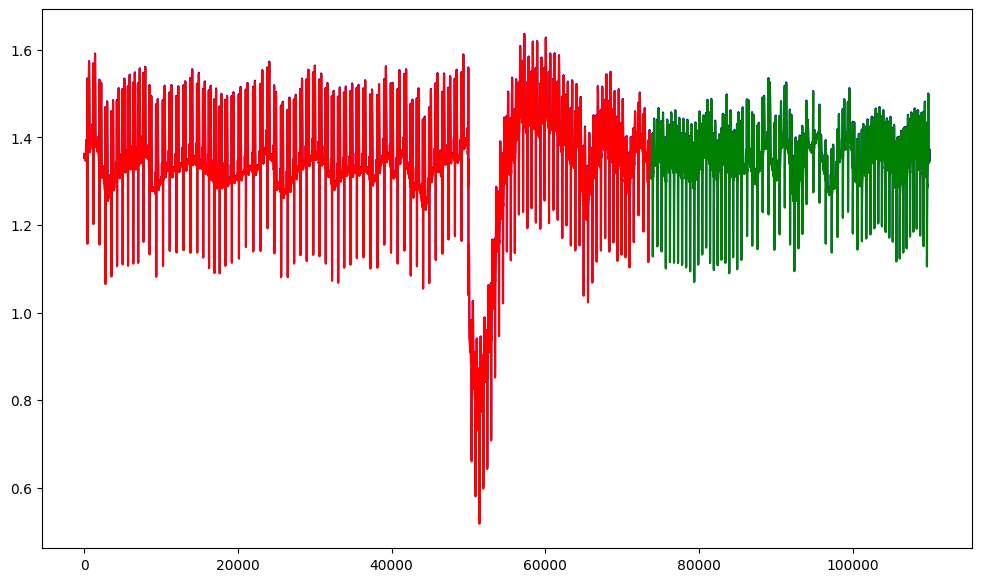

Метрики для пациента 27:
MSE: 4.900709e-05
RMSE: 0.007000506325906221
MAE: 0.0040003075
MAPE: 0.31472963746637106
R2: 0.9977401882654712


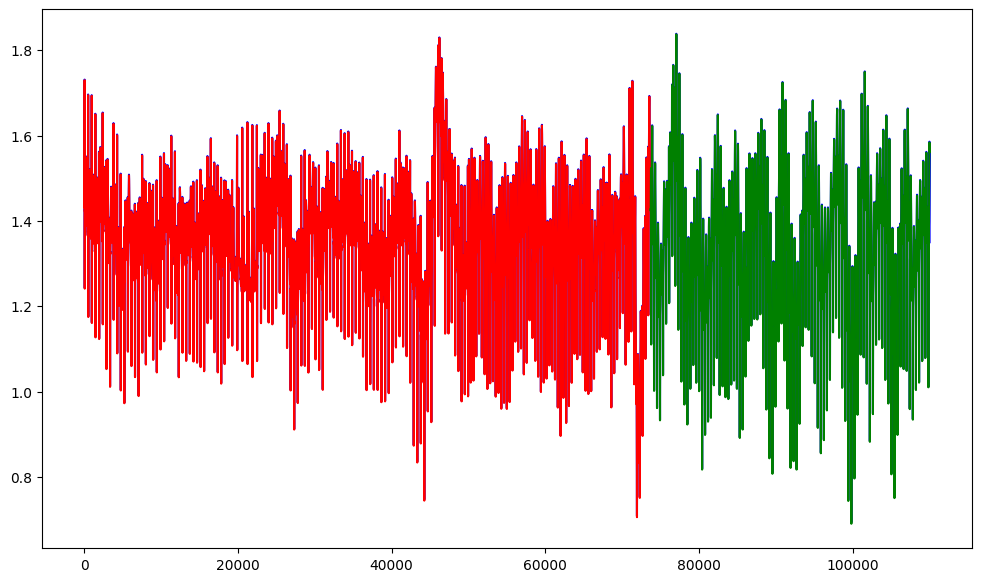

In [24]:
validate_on_new_users(model)